# Jonathan Halverson
# Keeping it Fresh: Predict Restaurant Inspections
## Part 2b: Computing the correlation time of the violations

In this notebook we compute the correlation time of the violations:

$<x(t) - x_0><x(0) - x_0> \sim exp(-t / \tau)$

Here is the format of the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [92]:
from helper_methods import drop_duplicate_inspections

df = pd.read_csv('data/training_labels.txt', parse_dates=['date'])
df = df.sort_values(['restaurant_id', 'date'])
df = drop_duplicate_inspections(df, threshold=60)
df = df[(df.date >= pd.to_datetime('2008-01-01')) & (df.date <= pd.to_datetime('2014-12-31'))]
df.head()

,id,date,restaurant_id,*,**,***
551,24765,2008-03-26,0ZED0WED,3,1,0
5460,25193,2008-10-08,0ZED0WED,6,2,4
3641,12775,2009-03-03,0ZED0WED,3,0,0
18452,25850,2009-07-23,0ZED0WED,1,0,2
10227,17443,2009-12-02,0ZED0WED,3,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20288 entries, 1801 to 5854
Data columns (total 6 columns):
id               20288 non-null int64
date             20288 non-null datetime64[ns]
restaurant_id    20288 non-null object
*                20288 non-null int64
**               20288 non-null int64
***              20288 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.1+ MB


### Below are two samples of the violation data

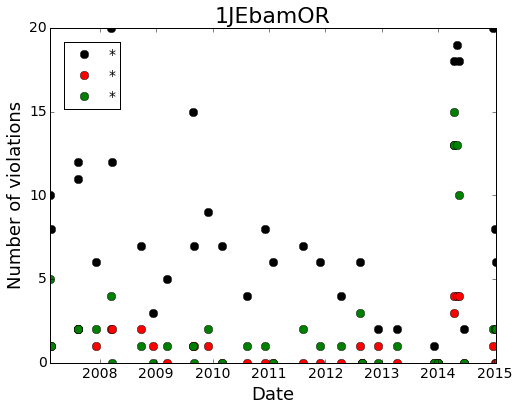

In [4]:
plt.plot(df[df.restaurant_id == '1JEbamOR'].date, df[df.restaurant_id == '1JEbamOR']['*'], 'ko', label='*')
plt.plot(df[df.restaurant_id == '1JEbamOR'].date, df[df.restaurant_id == '1JEbamOR']['**'], 'ro', label='*')
plt.plot(df[df.restaurant_id == '1JEbamOR'].date, df[df.restaurant_id == '1JEbamOR']['***'], 'go', label='*')
plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.legend(loc='upper left')
plt.title('1JEbamOR')

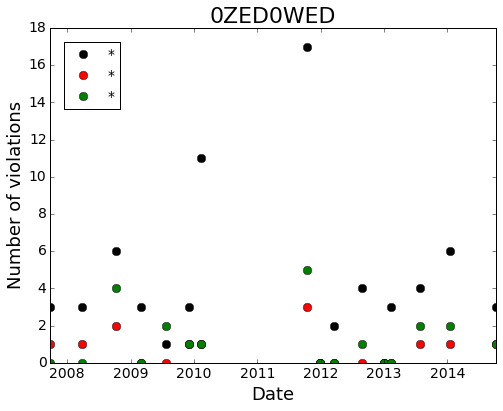

In [5]:
plt.plot(df[df.restaurant_id == '0ZED0WED'].date, df[df.restaurant_id == '0ZED0WED']['*'], 'ko', label='*')
plt.plot(df[df.restaurant_id == '0ZED0WED'].date, df[df.restaurant_id == '0ZED0WED']['**'], 'ro', label='*')
plt.plot(df[df.restaurant_id == '0ZED0WED'].date, df[df.restaurant_id == '0ZED0WED']['***'], 'go', label='*')
plt.xlabel('Date')
plt.ylabel('Number of violations')
plt.legend(loc='upper left')
plt.title('0ZED0WED')

### Let's look for a seasonal dependence

First load the weather data:

In [61]:
# https://www.wunderground.com/history/airport/KBOS/2015/1/1/CustomHistory.html
bos_wthr = pd.read_csv('data/bostom_weather.csv', parse_dates=['EST'])
bos_wthr['weekofyear'] = bos_wthr['EST'].apply(lambda x: x.weekofyear)
bos_wthr.head(3).transpose()

,0,1,2
EST,2015-01-01 00:00:00,2015-01-02 00:00:00,2015-01-03 00:00:00
Max TemperatureF,33,41,37
Mean TemperatureF,28,36,30
Min TemperatureF,22,31,22
Max Dew PointF,16,17,36
MeanDew PointF,8,15,20
Min DewpointF,5,11,8
Max Humidity,53,53,100
Mean Humidity,43,45,72
Min Humidity,32,37,43


In [103]:
df['weekofyear'] = df.date.apply(lambda x: x.weekofyear)
weekofyear_violations = df.groupby('weekofyear').agg({'*':[np.size, np.mean], '**':[np.mean], '***':[np.mean]})
weekofyear_violations.head()

*                 ***        **
           size      mean      mean      mean
weekofyear                                   
1           985  1.302538  0.279188  0.088325
2           404  4.198020  0.871287  0.331683
3           306  3.836601  0.934641  0.297386
4           296  3.675676  0.979730  0.293919
5           361  3.495845  0.806094  0.246537

(0, 100)

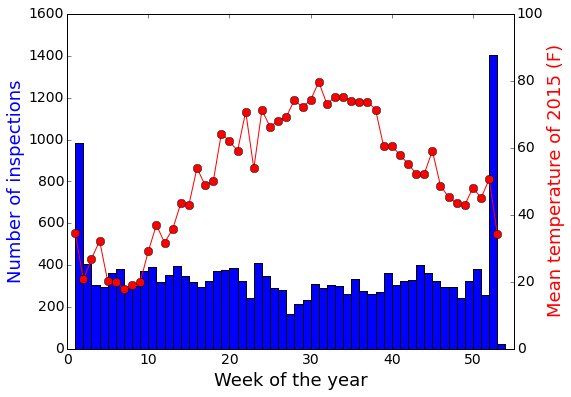

In [106]:
fig, ax1 = plt.subplots()
ax1.bar(weekofyear_violations.index, weekofyear_violations[('*', 'size')], width=1)
ax1.set_xlabel('Week of the year')
ax1.set_ylabel('Number of inspections', color='b')

mean_T_by_week = bos_wthr.groupby('weekofyear').agg({'Mean TemperatureF': [np.mean]})
ax2 = ax1.twinx()
#ax2.plot(bos_wthr.EST.apply(lambda x: x.dayofyear / 7.0), bos_wthr['Mean TemperatureF'], 'r')
ax2.plot(mean_T_by_week.index, mean_T_by_week, 'r', marker='o')
ax2.set_ylabel('Mean temperature of 2015 (F)', color='r')
ax2.set_xlim(0, 55)
ax2.set_ylim(0, 100)

In [102]:
from scipy.stats import pearsonr, spearmanr
print pearsonr(mean_T_by_week[('Mean TemperatureF', 'mean')][1:-2], weekofyear_violations[('*', 'size')][1:-2])
print spearmanr(mean_T_by_week[('Mean TemperatureF', 'mean')], weekofyear_violations[('*', 'size')])

(-0.4306029673801034, 0.0017994298505693317)
SpearmanrResult(correlation=-0.3675317099719112, pvalue=0.0067825032049352429)


There is an inverse correlation between the number of inspections and the mean weekly temperature. Note that when the first and last weeks are not removed the Pearson result is much different -- not surprising since it is sensitive to outliers.

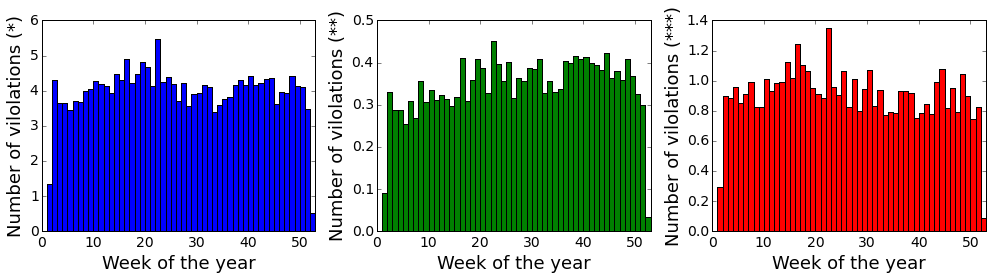

In [95]:
colors = ['b', 'g', 'r']
stars = ['*', '**', '***']
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
for i in range(3):
    ax[i].bar(weekofyear_violations.index, weekofyear_violations[(stars[i], 'mean')], width=1, color=colors[i])
    ax[i].set_xlabel('Week of the year')
    ax[i].set_ylabel('Number of vilolations (' + stars[i] + ')')
    ax[i].set_xlim(0, 53)
plt.tight_layout()

In [101]:
for star in stars:
    print star, pearsonr(mean_T_by_week[('Mean TemperatureF', 'mean')][1:-2], weekofyear_violations[(star, 'mean')][1:-2])
    print star, spearmanr(mean_T_by_week[('Mean TemperatureF', 'mean')], weekofyear_violations[(star, 'mean')])

* (-0.1179833507731374, 0.41448695976267635)
* SpearmanrResult(correlation=-0.12503276075052652, pvalue=0.37236361357332359)
** (0.52644375291441703, 8.6023712624799637e-05)
** SpearmanrResult(correlation=0.51263028706294556, pvalue=8.6934208487038402e-05)
*** (-0.19481504234300284, 0.17518225707363033)
*** SpearmanrResult(correlation=-0.20736649098354012, pvalue=0.13625026508153976)


### Compute the correlation time

In [105]:
df = df.sort_values(['restaurant_id', 'date'])
df

,id,date,restaurant_id,*,**,***,weekofyear
551,24765,2008-03-26,0ZED0WED,3,1,0,13
5460,25193,2008-10-08,0ZED0WED,6,2,4,41
3641,12775,2009-03-03,0ZED0WED,3,0,0,10
18452,25850,2009-07-23,0ZED0WED,1,0,2,30
10227,17443,2009-12-02,0ZED0WED,3,1,1,49
11543,4180,2010-02-08,0ZED0WED,11,1,1,6
20637,3527,2011-10-14,0ZED0WED,17,3,5,41
14848,22246,2011-12-28,0ZED0WED,0,0,0,52
21555,17990,2012-03-21,0ZED0WED,2,0,0,12
6720,1601,2012-08-27,0ZED0WED,4,0,1,35


For each restaurant compute average * then loop over all time origins and compute t_diff and <x-x_0><x-x_0> then plot and fit to exponential then compute tau which is the decorrelation time which will be less than the average time between inspections.

Need dictionary to store t_diff (in weeks between dates).